# Main Program file for Cancer Predictive Model (Jupyter Notebook Version)
## By: Group CL_04

### Importing Libraries

In [1]:
# Libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import time
import os, random, shutil
import copy

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import torchvision

from torchvision import *
from torch.utils.data import Dataset, DataLoader
from torchvision.io import read_image
from PIL import Image

### Dividing Dataset (70% training, 30% testing)

In [2]:
def img_train_test_split(root_dir, classes_dir, test_ratio):
    '''
    This function splits a folder with subfolders into train and test datasets
    :param root_dir: a string corresponding to the file path of the folder of subfolders of images
    :param classes_dir: a list of strings of subfolder names
    :param test_ratio: a float of the ratio of test dataset to train dataset
    :return: None
    '''

    for cls in classes_dir:
        # create a new train and test directory for cls
        os.makedirs(root_dir + 'train/' + cls)
        os.makedirs(root_dir + 'test/' + cls)

        # get pathname of cls
        src = root_dir + cls

        # split the filenames into chosen training and testing ratio
        allFileNames = os.listdir(src)
        np.random.shuffle(allFileNames)
        train_FileNames, test_FileNames = np.split(np.array(allFileNames),
                                                   [int(len(allFileNames) * (1 - test_ratio))])

        # copy images into new train folder for cls subfolder
        for name in train_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'train/' + cls)

        # copy images into new test folder for cls subfolder
        for name in test_FileNames:
            shutil.copy(root_dir + cls + '/' + name, root_dir + 'test/' + cls)
    return None

In [3]:
classes_dir = ['MSIMUT_JPEG', 'MSS_JPEG']
test_ratio = 0.3

In [6]:
# root_dir: filepath of coad_msi_mss with '/' at the back
root_dir = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/'
# root_dir = '/Users/elainealverina/Desktop/trial_dataset/'

#root_dir = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/'
#root_dir = '/Users/vionnietan/Desktop/cancer dataset/coad_msi_mss/'

In [7]:
img_train_test_split(root_dir, classes_dir, test_ratio)

## Custom Dataset

In [19]:
from torch.utils.data.sampler import SubsetRandomSampler
data_dir = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/train'

def load_split_train_test(datadir, valid_size = .2):
    data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
    data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

    train_data = datasets.ImageFolder(datadir, transform=data_transformation_train)
    test_data = datasets.ImageFolder(datadir, transform=data_transformation_test)

    num_train = len(train_data)
    indices = list(range(num_train))
    split = int(np.floor(valid_size * num_train))
    np.random.shuffle(indices)
    
    train_idx, test_idx = indices[split:], indices[:split]
    train_sampler = SubsetRandomSampler(train_idx)
    test_sampler = SubsetRandomSampler(test_idx)
    trainloader = torch.utils.data.DataLoader(train_data, sampler=train_sampler, batch_size=128)
    testloader = torch.utils.data.DataLoader(test_data, sampler=test_sampler, batch_size=128)
    return trainloader, testloader

trainloader, testloader = load_split_train_test(data_dir, .2)
print(trainloader.dataset.classes)

['MSIMUT_JPEG', 'MSS_JPEG']


### Data Augmentation and Normalization

In [ ]:
# batch_size = 128
learn_rate = 1e-3

data_transformation_train = transforms.Compose([transforms.RandomHorizontalFlip(), transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])
data_transformation_test = transforms.Compose([transforms.ToTensor(), transforms.Normalize([0.485, 0.456, 0.406], [0.229, 0.224, 0.225])])

root_dir_train = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/train'
#root_dir_train = '/Users/elainealverina/Desktop/trial_dataset/train'

root_dir_test = '/Users/vionnietan/Desktop/trial_dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Documents/GitHub/FIT3164-LocalRepo/FIT3164/cancer dataset/coad_msi_mss/test'
#root_dir_test = '/Users/elainealverina/Desktop/trial_dataset/test'


train_image_dataset = datasets.ImageFolder(root = root_dir_train, transform=data_transformation_train)
test_image_dataset = datasets.ImageFolder(root = root_dir_test, transform=data_transformation_test)



### Prepare DataLoader

train_image_dataloader = DataLoader(train_image_dataset, batch_size=128, shuffle=True)
test_image_dataloader = DataLoader(test_image_dataset, batch_size=128, shuffle=True)

In [20]:
# Switch to GPU
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
resnet18 = models.resnet18(pretrained=True)
print(resnet18)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

### Data Visualization (Display some images)

In [ ]:
#class_names = train_image_dataset.class_names
def show_image(images, labels, preds):
    plt.figure(figsize=(8,4))
    for i, image in enumerate(images):
        print('i',i)
        print('image',image)
        if i < 5:
            plt.subplot(1, 6, i+1, xticks=[], yticks=[])
            image = image.cpu() if device else image
            image = image.numpy().transpose((1, 2, 0))

            # Denormalize image
            mean = np.array([0.485, 0.456, 0.406])
            std = np.array([0.229, 0.224, 0.225])
            image = std * image + mean
            image = np.clip(image, 0, 1)
            plt.imshow(image)
            colour = 'green' if preds[i] == labels[i] else 'red'
            
            plt.xlabel(f'{labels[i]}')
            plt.ylabel(f'{preds[i]}', color=colour)

    plt.show()

i 0
image tensor([[[ 1.1358,  0.0912,  0.5707,  ...,  1.1700,  1.2899,  1.2214],
         [ 1.4440,  0.2111,  0.4337,  ...,  0.9303,  1.0502,  1.1529],
         [ 1.3070,  0.2111,  0.1083,  ...,  0.7591,  0.9132,  1.3070],
         ...,
         [ 1.6324,  1.2214,  0.9988,  ...,  0.7591,  0.7419,  0.6563],
         [ 0.8961,  0.8447,  0.8447,  ...,  0.2967,  0.0227, -0.1486],
         [ 1.1187,  0.9132,  0.9132,  ...,  0.2111, -0.4054, -0.0287]],

        [[ 0.4503, -0.6702, -0.2500,  ...,  0.2402,  0.3803,  0.5378],
         [ 0.6954, -0.5826, -0.3200,  ...,  0.0651,  0.2052,  0.2402],
         [ 0.4678, -0.6001, -0.6527,  ..., -0.0399,  0.0826,  0.2052],
         ...,
         [ 0.3627, -0.1625, -0.4776,  ..., -0.3375, -0.1625, -0.0399],
         [-0.3200, -0.4601, -0.5301,  ..., -0.5651, -0.7752, -0.8452],
         [ 0.1352, -0.1099, -0.1625,  ..., -0.3375, -1.0378, -0.7402]],

        [[ 1.4025,  0.5311,  1.1411,  ...,  1.3154,  1.3677,  1.4200],
         [ 1.5942,  0.5485,  0.9319

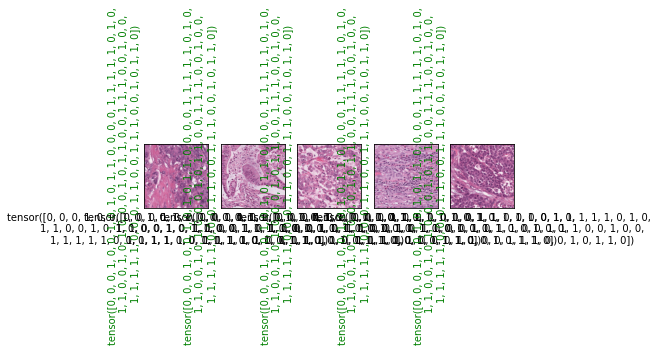

In [ ]:
# Show Images of Training Data
images, labels = next(iter(train_image_dataloader))
show_image(images,labels, labels)

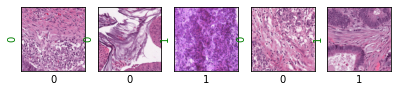

In [ ]:
# Show Images of Testing Data
images_test, labels_test = next(iter(test_image_dataloader))
show_image(images_test,labels_test, labels_test)

### Creating the Model - Load resnet18

In [30]:
# Freeze parameters so we don't backprop through them
for param in resnet18.parameters():
    param.requires_grad = False
    
# Classifier architecture to put on top of resnet18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# Using Adam Optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)
resnet18.to(device)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [18]:
# Classifier architecture to put on top of resnet18
resnet18.fc = torch.nn.Linear(in_features=512, out_features=3)
loss_fn = torch.nn.CrossEntropyLoss()

# Using Adam Optimizer
optimizer = torch.optim.Adam(resnet18.parameters(), lr=0.0001)

### Freeze Parameters

### Training Model

In [27]:
len(trainloader.dataset)

70

In [32]:
def train(epochs):
    print('Started training...')
    for e in range(0, epochs):
        print('='*20)
        print(f'Starting epoch {e+1}/{epochs}')
        print('='*20)
        
        train_loss = 0
        
        resnet18.train()   # set to training mode
        
        for train_step, (images, labels) in enumerate(trainloader):
            
            # Refresh optimizer and set gradients to zero
            optimizer.zero_grad()
            outputs = resnet18(images)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
            train_loss += loss.item()
            
            if train_step % 20 == 0:
                print('\nEvaluating at step:', train_step)
                acc = 0.
                val_loss = 0.
                resnet18.eval()
                
                for val_step, (images, labels) in enumerate(testloader):
                    outputs = resnet18(images)
                    loss = loss_fn(outputs, labels)
                    val_loss += loss.item()
                    
                    _ , preds = torch.max(outputs, 1)
                    acc += sum((preds == labels).numpy())
                    
                val_loss /= (val_step + 1)
                #acc /= len(test_image_dataset)
                acc /= 15
                print(f'Val loss = {val_loss:.4f}, Accuracy = {acc:.4f}')
                # show_preds()
                
                resnet18.train()
                
                if acc > 0.97:
                    print('\nPerformance condition satisifed, hence stopping...')
                    return
                
        train_loss /= (train_step+1)
        print(f'\nTraining loss = {train_loss:.4f}')

In [33]:
train(epochs=3)

Started training...
Starting epoch 1/3

Evaluating at step: 0
Val loss = 1.0913, Accuracy = 0.4000

Training loss = 1.2962
Starting epoch 2/3

Evaluating at step: 0
Val loss = 1.0982, Accuracy = 0.4000

Training loss = 1.2644
Starting epoch 3/3

Evaluating at step: 0
Val loss = 1.0981, Accuracy = 0.4000

Training loss = 1.2282


In [36]:
epochs = 5
steps = 0
running_loss = 0
print_every = 1
train_losses, test_losses = [], []

for epoch in range(epochs):
    for inputs, labels in trainloader:
        steps += 1
        inputs, labels = inputs.to(device), labels.to(device)
        optimizer.zero_grad()
        logps = resnet18.forward(inputs)
        loss = loss_fn(logps, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
        
        if steps % print_every == 0:
            test_loss = 0
            accuracy = 0
            resnet18.eval()
            with torch.no_grad():
                for inputs, labels in testloader:
                    inputs, labels = inputs.to(device), labels.to(device)
                    logps = resnet18.forward(inputs)
                    batch_loss = loss_fn(logps, labels)
                    test_loss += batch_loss.item()
                    
                    ps = torch.exp(logps)
                    top_p, top_class = ps.topk(1, dim=1)
                    equals = top_class == labels.view(*top_class.shape)
                    accuracy += torch.mean(equals.type(torch.FloatTensor)).item()

            train_losses.append(running_loss/len(trainloader))
            test_losses.append(test_loss/len(testloader))                    
            print(f"Epoch {epoch+1}/{epochs}.. "
                  f"Train loss: {running_loss/print_every:.3f}.. "
                  f"Test loss: {test_loss/len(testloader):.3f}.. "
                  f"Test accuracy: {accuracy/len(testloader):.3f}")
            running_loss = 0
            resnet18.train()

Epoch 1/5.. Train loss: 1.044.. Test loss: 1.018.. Test accuracy: 0.429
Epoch 2/5.. Train loss: 1.057.. Test loss: 1.002.. Test accuracy: 0.500
Epoch 3/5.. Train loss: 1.002.. Test loss: 0.984.. Test accuracy: 0.500
Epoch 4/5.. Train loss: 0.983.. Test loss: 0.964.. Test accuracy: 0.571
Epoch 5/5.. Train loss: 0.985.. Test loss: 0.945.. Test accuracy: 0.571


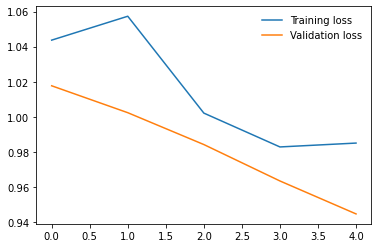

In [37]:
plt.plot(train_losses, label='Training loss')
plt.plot(test_losses, label='Validation loss')
plt.legend(frameon=False)
plt.show()